<a href="https://colab.research.google.com/github/eruru0411/git-test/blob/master/HR_iru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy            import stats
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics  import confusion_matrix, accuracy_score, f1_score, roc_auc_score,\
                             precision_score,recall_score, roc_curve, classification_report,precision_recall_curve
from sklearn                 import preprocessing
from sklearn.preprocessing   import StandardScaler,RobustScaler,MinMaxScaler, Binarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold
import warnings
warnings.filterwarnings(action="ignore")
barline = "\n============================================"
e = "\n"

In [ ]:
# 1. EDA  : 데이터 사전 탐색
#    0) Dataframe 살펴보기
#    1) 차트그리기
# 2. 결측치/이상치 --> 처리
# 3. 피쳐 전처리/가공
# 4. 학습/평가 : f1, auc
# 5. 검증(GridSearchCV, confusion_matrix)

import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy            import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import confusion_matrix, accuracy_score, f1_score, roc_auc_score,\
                             precision_score,recall_score, roc_curve, classification_report,precision_recall_curve
from sklearn                 import preprocessing
from sklearn.preprocessing   import StandardScaler,RobustScaler,MinMaxScaler, Binarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold
import warnings
warnings.filterwarnings(action="ignore")
barline = "\n============================================"
e = "\n"

# Dataframe 확인 ---------------------------------------
def MyCheckDataframe(df, target="target") :
    print("Check Dataframe ----------------------------")
    print("Shape :", e, df.shape)
    print("Info  :", e, df.info())
    print("Head  :", e, df.head())
    print("Count :", e, df[target].value_counts())

    y = df[target]
    X = df.drop(target, axis=1)
    print("Target Shape :", e, X.shape, y.shape, barline)
    return X, y
# X,y = CHECK_DATAFRAME(df, target="")


# -------------------------------------
# 4-2. IQR : 25%~75% 범위 값
# -------------------------------------
def MyCheckOutlier(df=None, column=None, print=None):
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    for k, v in df.items():
        Q1 = v.quantile(0.25)
        Q3 = v.quantile(0.75)
        IQR = Q3 - Q1
        IQR_weight = IQR * 1.5
        minimum = Q1 - IQR_weight
        maximum = Q3 + IQR_weight
        outlier_idx = v[(v < minimum) | (v> maximum)].index

        if print == True:
            perc = np.shape(outlier_idx)[0] * 100.0 / np.shape(df)[0]
            print("Column %s outliers = %.2f%%" % (k, perc))

    print(barline)
    return outlier_idx
    # Q1  = np.percentile(df[column].values, 25)
    # Q3  = np.percentile(df[column].values, 75)
    # IQR = Q3 - Q1
    # IQR_weight  = IQR * 1.5
    # minimum     = Q1 - IQR_weight
    # maximum     = Q3 + IQR_weight
    # outlier_idx = df[column][  (df[column] < minimum) | (df[column] > maximum)  ].index

# outlier_idx = CHECK_OUTLIER(df=df, column=col)
# print(col, oulier_idx)
# df.drop(outlier_idx, axis=0, inplace=True)
    #---------------------------------------------
    # numeric_columns = df.dtypes[df.dtypes != 'object'].index
    # for i, col in enumerate(numeric_columns) :
    #     oulier_idx = CHECK_OUTLIER(df=df, column=col)
    #     print(col , oulier_idx)
    #     #df.drop(outlier_idx, axis=0, inplace=True)


def MyCheckZeros(X):
    print("Check Zeros --------------------------------")
    for col in X.columns:
        gcnt = X[col][X[col] == 0].count()
        print(col, ":", gcnt, "(", np.round(gcnt / X.shape[0] * 100, 2), ")")
    print(barline)

def MyCheckNull(X):
    print("Check Null ---------------------------------")
    # print(df.isnull().sum())
    for col in X.columns:
        gcnt = X[col][X[col] == np.nan].count()
        print(col, ":", gcnt, "(", np.round(gcnt / X.shape[0] * 100, 2), ")")
    print(barline)

def MyScores(y_test, pred, proba, str=None) :
    print("Scores : {} ---------" .format(str))
    acc       = accuracy_score(y_test, pred)
    f1        = f1_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall    = recall_score(y_test, pred)
    auc       = roc_auc_score(y_test, proba[:, 1].reshape(-1, 1))
    print("정확도{:.4f}  F1 {:.4f}=(정밀도{:.4f} 재현률{:.4f}) auc {:.4f}" .format(acc, f1, precision, recall, auc))
    cf_matrix = confusion_matrix(y_test, pred)
    print("Confusion Matrix", e, cf_matrix, barline)


def MySplitFitPredict(model, X, y, str=None, rate=0.2, prc=False, roc=False) :
    X_train ,X_test , y_train, y_test = train_test_split(X, y, test_size=rate, random_state=121)
    model.fit(X_train, y_train)
    pred  = model.predict(X_test)
    proba = model.predict_proba(X_test)

    MyScores(y_test, pred, proba, str)

    if prc == True:
        MyChartPrcRclCurve(y_test, proba)
    if roc == True:
        MyChartRocCurve(y_test, proba)
    return X_train, X_test, y_train, y_test, pred, proba
# rf_model = RandomForestClassifier()
# SPLIT_FIT_PREDICT(rf_model, X, y, str="최초점수", 0.5)
# SPLIT_FIT_PREDICT(rf_model, X, y)


def MyChartHeatmap(df, targetClass=None, topn=0):
    plt.figure(figsize=(10,6))
    if   topn > 0 :
        idx = df.corr().nlargest(topn, targetClass).index
        print("Correlation: Top", topn, e, idx, barline)
        sns.heatmap(df[idx].corr(), annot=True, fmt=".2g", cmap="Blues")
    elif topn < 0 :
        idx = df.corr().nsmallest(-1 * topn, targetClass).index
        print("Correlation: Bottom", -topn, e, idx, barline)
        sns.heatmap(df[idx].corr(), annot=True, fmt=".2g", cmap="Blues")
        # cols = ['V12', 'V14', 'V10', 'V17', 'V3','Class']
        # sns.heatmap(df[cols].corr(), annot=True, fmt=".2g", cmap="Blues")
    else :
        sns.heatmap(df.corr(), annot=True, fmt=".2g", cmap="Blues")
    plt.show()
# CHART_HEATMAP(df, 5)
# CHART_HEATMAP(df, -5)
# CHART_HEATMAP(df)

def MyCrossValidate(model, X, y, cv=5) :
    print("Cross Validation ---------------------------")
    my_score   = {"acc":"accuracy", "f1":"f1"}
    score_list = cross_validate(model, X, y, scoring=my_score, cv=5, verbose=0)
    score_df   = pd.DataFrame(score_list)
    print("cross_validation 평균 정확도 : " , score_df["test_acc"].mean())
    print("cross_validation 평균 f1    : "    , score_df["test_f1"].mean())
    print(barline)
# CROSS_VALIDATION(model, X, y)

def MyGridSearchCV(my_hyper_param, model, X, y) :
    print("GridSerchCV --------------------------------")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121)
    my_score  = {"acc": "accuracy", "f1": "f1"}
    gcv_model = GridSearchCV(model, param_grid=my_hyper_param, scoring=my_score, refit="f1", cv=5, verbose=0)
    gcv_model.fit(X_train, y_train)

    # print("best_estimator:", gcv_model.best_estimator_)
    print("best_params :", gcv_model.best_params_)
    print("best_score  :", gcv_model.best_score_)
    print("GridSearchCV 평균 정확도 : ", gcv_model.cv_results_["mean_test_acc"].mean())  #mean_test_(본인의score키값)
    print("GridSearchCV 평균 F1    : ", gcv_model.cv_results_["mean_test_f1"].mean())
    print(barline)
# my_hyper_param = {  "n_estimators"     :[100]}
# GRIDSEARCHCV(my_hyper_param, model, X_train, y_train)


def MyGroupFillNa(bycol, cols, tcol):
    dict = df.groupby(by=[bycol])[cols].mean().astype(np.int32).to_dict()
    fill_mean_func = lambda gname: gname.fillna(dict[bycol][gname[tcol]])
    df   = df.groupby(bycol).apply(fill_mean_func)
    return df
# df["Name2"] = df["Name"].str.extract("([A-Za-z]+)\.")
# dict = df.groupby(by=["Name2"])[["Name2","Age"]].mean().astype(np.int32).to_dict()
# fill_mean_func = lambda gname: gname.fillna(dict['Age'][gname.name])
# df = df.groupby('Name2').apply(fill_mean_func)
# df = GROUP_FILLNA_MEAN("Name2",["Name2","Age"],"name"

def MyReplace(target_df, a, b) :
    target_df = target_df.replace(a, b)
    return target_df
#DF_REPLACE(X[["Insulin", "BMI"]], 0, X[["Insulin", "BMI"]].median())
#X["BMI"] = DF_REPLACE(X["BMI"], 0, 99)

# def MyScaler(scaler_model):
#     scaler   = scaler_model
#     X_scaler = scaler.fit_transform(X)
#     return X_scaler
# # X_scaler = SCALER(StandardScaler())
def MyScaler(X):
    scaler   = StandardScaler()
    X_scaler = scaler.fit_transform(X)
    return X_scaler
# X_scaler = SCALER(StandardScaler())

def MyChartPrcRclCurve(y_test, proba):
    precision, recall, th = precision_recall_curve(y_test, proba[:, 1])
    print(len(precision), len(recall), len(th), barline)
    plt.plot(th, precision[:len(th)], label="precision")
    plt.plot(th, recall[:len(th)],    label="recall")
    plt.xlabel("threadshold"); plt.ylabel("precision & recall value")
    plt.legend()  # plt.legend(["precision","recall"])
    plt.grid()
    plt.show()

def MyChartRocCurve(y_test, proba):
    fpr, tpr, th = roc_curve(y_test, proba[:, 1])
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], label='th:0.5')
    # plt.title(auc)
    plt.xlabel("FPR"); plt.ylabel("TPR(recall)")
    plt.grid()
    plt.show()


# ------------------------------------------------
# precision_recall_curve : 임계치 튜닝을 통한 점수 보정
#-------------------------------------------------
ths = [.4, .43, .45, .47, .49, .51, .53]
def MyPrcRclTune(model, X, y, ths=ths):
    for th in ths:
        print("N : P =", th, ":", 1 - th)
        prob = MySplitFitPredict(model, X, y, prc=True)
        print(prob[4])
        bn = Binarizer(threshold=ths)
        fit_trans = bn.fit_transform(prob[:, 1].reshape(-1, 1))  # 세로로 reshape

        auc = roc_auc_score(y_test, prob[:, 1].reshape(-1, 1))
        print(auc)

# ------------------------------------------------
# boxplot : Boston-house-prices 사용
# distplot: Boston-house-prices 사용
#-------------------------------------------------
def MyPlots(data, plot, ncols=7, nrows=2):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 10))
    index = 0
    axs = axs.flatten()     # 1차원으로 바꿔주기
    for k, v in data.items():
        if   plot == 'distplot':
            sns.distplot(v, ax=axs[index])
        elif plot == 'boxplot':
            sns.boxplot(y=k, data=data, ax=axs[index])
        index += 1
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")
df = train_df.append(test_df)
df.shape

(78298, 14)

In [ ]:
print(train_df.isnull().sum())

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64


In [ ]:
# df.info()

In [ ]:
# test_df = pd.read_csv("test.csv")
# test_df.info()

In [ ]:
# df = train_df.append(test_df)

In [ ]:
# df.head()

In [ ]:
# df.tail()

In [ ]:
# df["education"].value_counts() # 머신러닝으로 채워넣기(bike 참조)
# df["recruitment_channel"].value_counts() #0~2 범주화 시키기 0:인력소싱업체 1:추천? 2:기타
# df["department"].value_counts() #범주화 시키기 

In [ ]:
df.isnull().sum()

employee_id                 0
department                  0
region                      0
education                3443
gender                      0
recruitment_channel         0
no_of_trainings             0
age                         0
previous_year_rating     5936
length_of_service           0
KPIs_met >80%               0
awards_won?                 0
avg_training_score          0
is_promoted             23490
dtype: int64

In [ ]:
# import missingno as msno
# msno.bar(df)

In [ ]:
# df.describe()

In [ ]:
# df.plot(kind='box', subplots=True, figsize=(20, 15), layout=(4,10), sharex=False, sharey=False)
# plt.show()

In [ ]:
# plt.figure(figsize=(8, 4))
# # sns.countplot(df['gender'], hue=df['is_promoted'],palette='pastel')
# sns.countplot(df['department'], hue=df['is_promoted'],palette='pastel')
# plt.xticks(rotation=90)
# plt.show()

In [ ]:
df1 = df.set_index('employee_id') # df.drop("employee_id", axis=1)

# previous_year_rating: length_of_service가 1인 사람(새로운 직원)인 경우 전년도 평가 지표가 없음
df1["previous_year_rating"] = df1["previous_year_rating"].fillna(0)

# 나이: 20~60 구간? 5년..? 20~25, 26~30, 31~35, 36~40, 41~50, 50up
df1["age"].value_counts().sort_index()

def age_drop(age):
  if   age <= 25: cate = 0
  elif age <= 30: cate = 1
  elif age <= 35: cate = 2
  elif age <= 40: cate = 3
  elif age <= 50: cate = 4
  else:           cate = 5
  return cate

df1["age_cate"] = df1["age"].apply(lambda x: age_drop(x))
df1["age_cate"].value_counts()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78298 entries, 65438 to 5973
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            78298 non-null  object 
 1   region                78298 non-null  object 
 2   education             74855 non-null  object 
 3   gender                78298 non-null  object 
 4   recruitment_channel   78298 non-null  object 
 5   no_of_trainings       78298 non-null  int64  
 6   age                   78298 non-null  int64  
 7   previous_year_rating  78298 non-null  float64
 8   length_of_service     78298 non-null  int64  
 9   KPIs_met >80%         78298 non-null  int64  
 10  awards_won?           78298 non-null  int64  
 11  avg_training_score    78298 non-null  int64  
 12  is_promoted           54808 non-null  float64
 13  age_cate              78298 non-null  int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 9.0+ MB


In [ ]:
# length_of_service: 1, 2~4, 5~7, 8~10, 11~20, 21up
df1["length_of_service"].value_counts().sort_index()

def los_drop(year):
  if   year ==  1: cate = 0   # 신입
  elif year <=  4: cate = 1
  elif year <=  7: cate = 2
  elif year <= 10: cate = 3
  elif year <= 20: cate = 4
  else:            cate = 5   # 20년 넘게 근속
  return cate

df1["workyear"] = df1["length_of_service"].apply(lambda x: los_drop(x))

df1["workyear"].value_counts()

1    29367
2    23091
3    10979
4     7606
0     6539
5      716
Name: workyear, dtype: int64

In [ ]:
df1["gender"] = df1["gender"].apply(lambda x: 0 if x == "f" else 1)

df1["edu"]  = df1["education"].map({"Below Secondary": 0, "Bachelor's": 1, "Master's & above": 2})
df1["ch"]   = df1["recruitment_channel"].map({"other": 0, "sourcing": 1, "referred": 2})

df1.drop("education", axis=1, inplace=True)
df1.drop("recruitment_channel", axis=1, inplace=True)
df1.drop("age", axis=1, inplace=True)
df1.drop("length_of_service", axis=1, inplace=True)

df1.rename(columns={df1.columns[3]: 'train_no',
                    df1.columns[4]: 'last_rate',
                    df1.columns[5]: 'KPI80',
                    df1.columns[6]: 'awards',
                    df1.columns[7]: 'avg_score'}, inplace=True)

df1.head()

,department,region,gender,train_no,last_rate,KPI80,awards,avg_score,is_promoted,age_cate,workyear,edu,ch
employee_id,,,,,,,,,,,,,
65438,Sales & Marketing,region_7,0,1,5.0,1,0,49,0.0,2,3,2.0,1
65141,Operations,region_22,1,1,5.0,0,0,60,0.0,1,1,1.0,0
7513,Sales & Marketing,region_19,1,1,3.0,0,0,50,0.0,2,2,1.0,1
2542,Sales & Marketing,region_23,1,2,1.0,0,0,50,0.0,3,3,1.0,0
48945,Technology,region_26,1,1,3.0,0,0,73,0.0,4,1,1.0,0


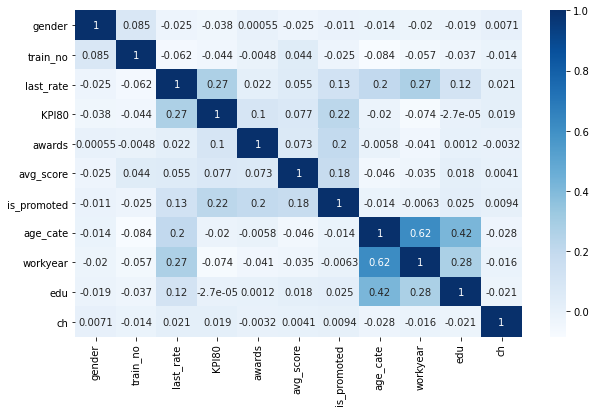

In [ ]:
MyChartHeatmap(df1)

In [ ]:
# encoding으로 가져가기

last_rate
KPI80
awards
avg_score
- 중요 피쳐만 분석

In [ ]:
get_col = ["last_rate", "KPI80", "awards", "avg_score", "is_promoted"]
df_only4 = df1[get_col]

df_only4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78298 entries, 65438 to 5973
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   last_rate    78298 non-null  float64
 1   KPI80        78298 non-null  int64  
 2   awards       78298 non-null  int64  
 3   avg_score    78298 non-null  int64  
 4   is_promoted  54808 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 3.6 MB


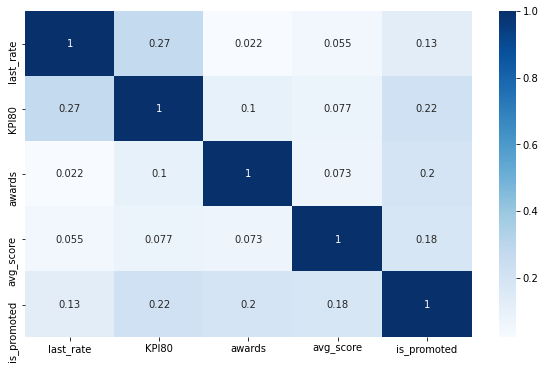

In [ ]:
MyChartHeatmap(df_only4, "is_promoted")

In [ ]:
df_only4.head()
df_only4.describe()

,last_rate,KPI80,awards,avg_score,is_promoted
count,78298.000000,78298.000000,78298.000000,78298.000000,54808.000000
mean,3.079593,0.354032,0.023053,63.349664,0.085170
std,1.499173,0.478222,0.150073,13.383664,0.279137
min,0.000000,0.000000,0.000000,39.000000,0.000000
25%,2.000000,0.000000,0.000000,51.000000,0.000000
50%,3.000000,0.000000,0.000000,60.000000,0.000000
75%,4.000000,1.000000,0.000000,76.000000,0.000000
max,5.000000,1.000000,1.000000,99.000000,1.000000


In [ ]:
#import math

df_only4["sqrt_score"] = np.sqrt(df_only4["avg_score"])
df_only4.head()

,last_rate,KPI80,awards,avg_score,is_promoted,sqrt_score
employee_id,,,,,,
65438,5.0,1,0,49,0.0,7.000000
65141,5.0,0,0,60,0.0,7.745967
7513,3.0,0,0,50,0.0,7.071068
2542,1.0,0,0,50,0.0,7.071068
48945,3.0,0,0,73,0.0,8.544004


In [ ]:
df_only4.drop("avg_score", axis=1, inplace=True)


In [ ]:
df_only4["last_rate"] = df_only4["last_rate"].astype(np.int32)
df_only4["is_promoted"] = df_only4["is_promoted"].apply(lambda x: 0 if x == 0.0 else 1)

df_only4.head()

,last_rate,KPI80,awards,is_promoted,sqrt_score
employee_id,,,,,
65438,5,1,0,0,7.000000
65141,5,0,0,0,7.745967
7513,3,0,0,0,7.071068
2542,1,0,0,0,7.071068
48945,3,0,0,0,8.544004


여기서부터 df_only4로 바꿔서 실행

In [ ]:
train = df_only4.iloc[ :54808, :]
test =  df_only4.iloc[54808:, :]

# print(train.shape , test.shape)

y_train = train["is_promoted"]                             # 학습용 답안
X_train = train.drop("is_promoted", axis=1)                # 학습용 답안
test = test.drop("is_promoted", axis=1)  #, inplace=True)  # 시험용 문제
print(y_train.shape , X_train.shape, test.shape)

(54808,) (54808, 4) (23490, 4)


In [ ]:
df_only4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78298 entries, 65438 to 5973
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   last_rate    78298 non-null  int32  
 1   KPI80        78298 non-null  int64  
 2   awards       78298 non-null  int64  
 3   is_promoted  78298 non-null  int64  
 4   sqrt_score   78298 non-null  float64
dtypes: float64(1), int32(1), int64(3)
memory usage: 3.3 MB


In [ ]:
rf_model = RandomForestClassifier()
MySplitFitPredict(rf_model, X_train, y_train)

Scores : None ---------
정확도0.9224  F1 0.2436=(정밀도0.7611 재현률0.1450) auc 0.8103
Confusion Matrix 
 [[9974   43]
 [ 808  137]] 


(             last_rate  KPI80  awards  sqrt_score
 employee_id                                      
 50466                4      1       0    6.928203
 25978                5      1       0    7.615773
 58383                3      1       0    8.485281
 71973                3      0       0    7.211103
 42417                5      1       0    7.549834
 ...                ...    ...     ...         ...
 31719                4      1       0    9.110434
 61150                2      0       0    6.928203
 155                  5      1       0    8.000000
 75073                3      1       0    7.745967
 42907                3      0       0    8.717798
 
 [43846 rows x 4 columns],              last_rate  KPI80  awards  sqrt_score
 employee_id                                      
 11342                3      1       0    7.681146
 8425                 3      0       0    7.810250
 71426                4      1       0    9.000000
 32435                4      0       0    7.141428
 57

In [ ]:
# def rateCheck(df, col=""):
#   rate_df = pd.DataFrame()
#   rate_df["count0"] = df[col][df["is_promoted"]==0].value_counts()
#   rate_df["count1"] = df[col][df["is_promoted"]==1].value_counts()
#   rate_df["rate0"] = rate_df["count0"]  / (rate_df["count0"] + rate_df["count1"]) * 100     # df["is_promoted"].count()
#   rate_df["rate1"] = rate_df["count1"]  / (rate_df["count0"] + rate_df["count1"]) * 100
#   print(rate_df)

# # rateCheck(df1, "region")

In [ ]:
# plt.figure(figsize=(12,8))
# sns.heatmap(df1.corr(), annot=True, fmt=".2g", cmap="Blues")

In [ ]:

def data_encoding( encoding_strategy , encoding_data , encoding_columns ):
    
    if encoding_strategy == "LabelEncoding":
        print("IF LabelEncoding")
        Encoder = LabelEncoder()
        for column in encoding_columns :
            print("column",column )
            encoding_data[ column ] = Encoder.fit_transform(tuple(encoding_data[ column ]))
        
    elif encoding_strategy == "OneHotEncoding":
        print("ELIF OneHotEncoding")
        encoding_data = pd.get_dummies(encoding_data)
        
    elif encoding_strategy == "TargetEncoding":
        print("ELIF TargetEncoding")
        ## Code Coming soon
        print("TargetEncoding")

    else :
        print("ELSE OneHotEncoding")
        encoding_data = pd.get_dummies(encoding_data)
        
    dtypes_list =['float64','float32','int64','int32']
    encoding_data.astype( dtypes_list[0] ).dtypes
    
    return encoding_data

In [ ]:
# df1 = pd.get_dummies(data=df1, columns=["department"], prefix="dept", drop_first = False)
# df1 = pd.get_dummies(data=df1, columns=["region"], prefix="", drop_first = False)

In [ ]:
# df1.info()
# print(df1.columns)

In [ ]:
# df1[:54808].isnull().sum()

In [ ]:
# df1.isnull().sum()

In [ ]:
# change_col = ['gender','train_no','last_rate','KPI80', 'awards',	'avg_score', 'age_cate', 'workyear', 'edu', 'ch']
# df1["edu"] = df1["edu"].astype('int32')

In [ ]:
# df2["gender"] = df2["gender"].astype('uint8')
# df2["train_no"] = df2["train_no"].astype('uint8')
# df2["KPI80"] = df2["KPI80"].astype('uint8')
# df2["awards"] = df2["awards"].astype('uint8')
# df2["avg_score"] = df2["avg_score"].astype('uint8')
# df2["age_cate"] = df2["age_cate"].astype('uint8')
# df2["workyear"] = df2["workyear"].astype('uint8')
# df2["ch"] = df2["ch"].astype('uint8')
# df2["last_rate"] = df2["last_rate"].astype('uint8')

In [ ]:
# # train_data_len = train_df.shape[0]
# # test_data_len = test_df.shape[0]

# train = df1.iloc[ :54808, :]
# test =  df1.iloc[54808:, :]

# # print(train.shape , test.shape)

# y_train = train["is_promoted"]               # 학습용 답안
# X_train = train.drop("is_promoted", axis=1)               # 학습용 답안
# test = test.drop("is_promoted", axis=1)  #, inplace=True)  # 시험용 문제
# print(y_train.shape , X_train.shape, test.shape)

In [ ]:
# df1.info()

In [ ]:
# X_train.info()

In [ ]:
# edu: null 채우기
# df = test
# target = "edu"

# edu_nan = df[df[target].isnull() == True]
# edu_012 = df[df[target].isnull() == False]

# col = df.loc[:, df.columns != target].columns

# rf_edu = RandomForestRegressor()
# rf_edu.fit(edu_012[col], edu_012[target])
# edu_val = rf_edu.predict(X = edu_nan[col])
# edu_nan[target] = edu_val
# test = edu_012.append(edu_nan)

In [ ]:
# 인코딩 해봅시다 !
train_all = df1.iloc[ :54808, :]
test_all  = df1.iloc[54808:, :]

	# region	gender	train_no	last_rate	KPI80	awards	avg_score	is_promoted	age_cate	workyear	edu	ch

enc_col = ['department', 'region', 'gender', 'edu', 'ch']
# print(train.shape , test.shape)

y_train_all = train_all["is_promoted"]                             # 학습용 답안
X_train_all = train_all.drop("is_promoted", axis=1)                # 학습용 답안
test_all = test_all.drop("is_promoted", axis=1)  #, inplace=True)  # 시험용 문제
# print(y_train.shape , X_train.shape, test.shape)
encoding_strategy = [ "LabelEncoding", "OneHotEncoding", "TargetEncoding", "ELSE" ]

X_train_encode = data_encoding( encoding_strategy[1] , X_train_all , enc_col )
# X_test_encode =  data_encoding( encoding_strategy[1] , X_test , enc_col )

# X_train = X_train[["no_of_trainings", "age", "previous_year_rating", "length_of_service", "KPIs_met >80%", "awards_won?", "avg_training_score" ]]
# X_test = X_test[["no_of_trainings", "age", "previous_year_rating", "length_of_service", "KPIs_met >80%", "awards_won?", "avg_training_score" ]]

# X_train_encode = pd.concat([X_train,X_train_encode], axis=1)
# X_test_encode = pd.concat([X_test,X_test_encode], axis=1)

display(X_train_encode.isnull().sum())

ELIF OneHotEncoding


gender                             0
train_no                           0
last_rate                          0
KPI80                              0
awards                             0
avg_score                          0
age_cate                           0
workyear                           0
edu                             2409
ch                                 0
department_Analytics               0
department_Finance                 0
department_HR                      0
department_Legal                   0
department_Operations              0
department_Procurement             0
department_R&D                     0
department_Sales & Marketing       0
department_Technology              0
region_region_1                    0
region_region_10                   0
region_region_11                   0
region_region_12                   0
region_region_13                   0
region_region_14                   0
region_region_15                   0
region_region_16                   0
r

In [ ]:
#test.isnull().sum() # edu null 처리 완료

In [ ]:
# edu: null 채우기
df = X_train_encode
target = "edu"

edu_nan = df[df[target].isnull() == True]
edu_012 = df[df[target].isnull() == False]

col = df.loc[:, df.columns != target].columns

rf_edu = RandomForestRegressor()
rf_edu.fit(edu_012[col], edu_012[target])
edu_val = rf_edu.predict(X = edu_nan[col])
edu_nan[target] = edu_val
X_train = edu_012.append(edu_nan)

In [ ]:
X_train.isnull().sum()

gender                          0
train_no                        0
last_rate                       0
KPI80                           0
awards                          0
avg_score                       0
age_cate                        0
workyear                        0
edu                             0
ch                              0
department_Analytics            0
department_Finance              0
department_HR                   0
department_Legal                0
department_Operations           0
department_Procurement          0
department_R&D                  0
department_Sales & Marketing    0
department_Technology           0
region_region_1                 0
region_region_10                0
region_region_11                0
region_region_12                0
region_region_13                0
region_region_14                0
region_region_15                0
region_region_16                0
region_region_17                0
region_region_18                0
region_region_

In [ ]:
# X_train_encode = data_encoding( encoding_strategy[1] , X_train_encode , "edu" )

# X_train.isnull().sum()

In [ ]:
rf_model = RandomForestClassifier()
MySplitFitPredict(rf_model, X_train, y_train)

Scores : None ---------
정확도0.9080  F1 0.0137=(정밀도0.0897 재현률0.0074) auc 0.5030
Confusion Matrix 
 [[9946   71]
 [ 938    7]] 


(             gender  train_no  ...  region_region_8  region_region_9
 employee_id                    ...                                  
 24935             1         1  ...                0                0
 39376             1         1  ...                0                0
 12538             1         1  ...                0                0
 22594             1         1  ...                0                0
 76786             1         1  ...                0                0
 ...             ...       ...  ...              ...              ...
 7803              0         1  ...                0                0
 45185             1         1  ...                0                0
 68991             1         1  ...                0                0
 40746             1         1  ...                0                0
 68463             1         2  ...                0                0
 
 [43846 rows x 53 columns],
              gender  train_no  ...  region_region_8  region

In [ ]:
# # Dataframe 확인 ---------------------------------------
# def MyCheckDataframe(df, target="target") :
#     # print("Check Dataframe ----------------------------")
#     # print("Shape :", e, df.shape)
#     # print("Info  :", e, df.info())
#     # print("Head  :", e, df.head())
#     # print("Count :", e, df[target].value_counts())

#     y = df[target]
#     X = df.drop(target, axis=1)
#     print("Target Shape :", e, X.shape, y.shape, barline)
#     return X, y

In [ ]:
# X, y = MyCheckDataframe(X_train, "is_promoted")

In [ ]:
# X_train.info()

In [ ]:
# y_train

In [ ]:
rf_model = RandomForestClassifier()
MySplitFitPredict(rf_model, X_train, y_train)

Scores : None ---------
정확도0.9087  F1 0.0118=(정밀도0.0882 재현률0.0063) auc 0.5071
Confusion Matrix 
 [[9955   62]
 [ 939    6]] 


(             gender  train_no  ...  region_region_8  region_region_9
 employee_id                    ...                                  
 24935             1         1  ...                0                0
 39376             1         1  ...                0                0
 12538             1         1  ...                0                0
 22594             1         1  ...                0                0
 76786             1         1  ...                0                0
 ...             ...       ...  ...              ...              ...
 7803              0         1  ...                0                0
 45185             1         1  ...                0                0
 68991             1         1  ...                0                0
 40746             1         1  ...                0                0
 68463             1         2  ...                0                0
 
 [43846 rows x 53 columns],
              gender  train_no  ...  region_region_8  region

Scores : 스케일링 적용 후 점수 ---------
정확도0.9078  F1 0.0137=(정밀도0.0875 재현률0.0074) auc 0.5007
Confusion Matrix 
 [[9944   73]
 [ 938    7]] 
680 680 679 


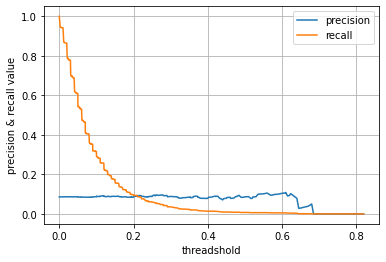

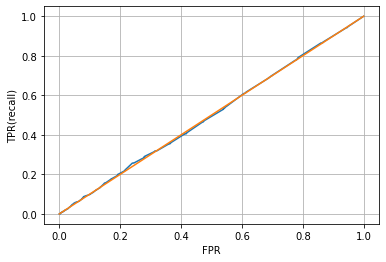

(array([[ 0.65094726, -0.41527615,  1.28387791, ..., -0.31133238,
         -0.1099789 , -0.08787657],
        [ 0.65094726, -0.41527615, -0.05262314, ...,  3.21200129,
         -0.1099789 , -0.08787657],
        [ 0.65094726, -0.41527615,  1.28387791, ..., -0.31133238,
         -0.1099789 , -0.08787657],
        ...,
        [ 0.65094726, -0.41527615, -2.05737473, ..., -0.31133238,
         -0.1099789 , -0.08787657],
        [ 0.65094726, -0.41527615,  1.28387791, ..., -0.31133238,
         -0.1099789 , -0.08787657],
        [ 0.65094726,  1.22606339,  0.61562739, ..., -0.31133238,
         -0.1099789 , -0.08787657]]),
 array([[ 0.65094726,  1.22606339, -0.05262314, ..., -0.31133238,
         -0.1099789 , -0.08787657],
        [ 0.65094726, -0.41527615, -0.05262314, ..., -0.31133238,
         -0.1099789 , -0.08787657],
        [ 0.65094726, -0.41527615, -0.05262314, ..., -0.31133238,
         -0.1099789 , -0.08787657],
        ...,
        [ 0.65094726,  1.22606339,  0.61562739, ..., -

In [ ]:
X_scaler = MyScaler(X_train)
MySplitFitPredict(rf_model, X_scaler, y_train, str="스케일링 적용 후 점수", rate=0.2, prc=True, roc=True)

In [ ]:
# ------------------------------------------------
# precision_recall_curve : 임계치 튜닝을 통한 점수 보정
#-------------------------------------------------
# ths = [.4, .43, .45, .47, .49, .51, .53]
# def MyPrcRclTune(model, X, y, ths=ths):
#     for th in ths:
#         print("N : P =", th, ":", 1 - th)
#         prob = MySplitFitPredict(model, X, y, prc=True)
#         print("prob\n", prob[4])
#         bn = Binarizer(threshold=ths)
#         fit_trans = bn.fit_transform(prob[:, 1].reshape(-1, 1))  # 세로로 reshape

#         auc = roc_auc_score(y_test, prob[:, 1].reshape(-1, 1))
#         print(auc)

# MyPrcRclTune(rf_model, X_train, y_train, ths=ths)

In [ ]:
# MyCrossValidate(rf_model, X_train, y_train)

In [ ]:
# # 할수록 점수가 떨어져용^^...ㅎㅎ f1 = 0.11055041071734745 -> 2/17 0.00을 보았다 ㅎㅎ
# my_hyper_param = {  "n_estimators"     :[100, 300],
#                     "max_depth"        :[3, 5, 7],
#                     "min_samples_leaf" :[3, 5, 7],
#                     "random_state"     :[121,]    }

# MyGridSearchCV(my_hyper_param, rf_model, X_train, y_train)

In [ ]:
# ------------------------------------
# Under Sampling: iloc
# ------------------------------------

# P_df = df_only4[df_only4["is_promoted"] == 1]
# N_df = df_only4[df_only4["is_promoted"] == 0][:len(P_df)]


# under_df = P_df.append(N_df)
# print(P_df.shape, N_df.shape, under_df.shape)

# y = under_df["is_promoted"]
# X = under_df.drop("is_promoted", axis=1)
# model = RandomForestClassifier()
# print(X.shape, y.shape)
# MySplitFitPredict(model, X_train, y_train, str="언더샘플링", rate=0.2)

In [ ]:
# ------------------------------------
# Over Sampling : SMOTE
# ------------------------------------
from imblearn.over_sampling import SMOTE

# print(df_only4.shape)
# print(df_only4["is_promoted"].value_counts)

y = df_only4["is_promoted"]
X = df_only4.drop("is_promoted", axis=1)
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_over, y_over = smote.fit_resample(X, y)

# print(X_over.shape, y_over.shape)
# print(pd.Series(y_over).value_counts())

model = RandomForestClassifier()
# print(X.shape, y.shape)
smote_result = MySplitFitPredict(model, X_over, y_over, str="오버샘플링", rate=0.2)
smote_pred = smote_result[4].reshape(-1, 1)
smote_pred.shape

Scores : 오버샘플링 ---------
정확도0.5610  F1 0.5105=(정밀도0.5697 재현률0.4625) auc 0.5785
Confusion Matrix 
 [[6659 3469]
 [5336 4592]] 


(20056, 1)

In [ ]:
#test = test.astype('int32')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23490 entries, 8724 to 5973
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   last_rate   23490 non-null  int32  
 1   KPI80       23490 non-null  int64  
 2   awards      23490 non-null  int64  
 3   sqrt_score  23490 non-null  float64
dtypes: float64(1), int32(1), int64(2)
memory usage: 825.8 KB


In [ ]:
from sklearn.tree      import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.metrics   import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121, shuffle=True)

dt_model  = DecisionTreeClassifier()
knn_model = KNeighborsClassifier()
rf_model  = RandomForestClassifier()

models = [dt_model, knn_model, rf_model]
for model in models :
    # fit : 학습하다
    model.fit(X_over, y_over)
    # predict : 시험
    y_pred = model.predict(test)
#     # score : 예측 정확도 확인
#     #score = f1_score(test, y_pred)  # 점수는 kaggle이, 나는 X

In [ ]:
y_pred.shape

(23490,)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
sub_df = pd.read_csv("sample_submission.csv")
prom_id = sub_df["employee_id"]
mydic = {"employee_id" : prom_id,
         "is_promoted" : y_pred.astype(np.int32) }
sub_df = pd.DataFrame(mydic)
sub_df.to_csv("/content/gdrive/My Drive/Colab Notebooks/submitted2.csv", index=None)